In [117]:
from pandas import DataFrame
from ucimlrepo import fetch_ucirepo
from typing import NamedTuple, List, Dict, Any
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from pprint import pprint


# Type definitions from:
# https://github.com/uci-ml-repo/ucimlrepo?tab=readme-ov-file#parameters
class UciMlData(NamedTuple):
    ids: DataFrame
    features: DataFrame
    targets: DataFrame
    original: DataFrame
    headers: List[str]


class UciMlDataset(NamedTuple):
    data: UciMlData
    metadata: Dict[str, Any]
    variables: DataFrame

In [118]:
from numpy import average
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline


def perform_cross_validation(
    pipeline: Pipeline,
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    folds: int = 5,
):
    """
    Perform cross-validation and return the mean scores for specified metrics.

    Parameters:
    - pipeline: The machine learning pipeline that includes preprocessing and a classifier.
    - X_train: Training feature set as a pandas DataFrame.
    - y_train: Training target as a pandas Series.
    - folds: Number of cross-validation folds.

    Returns:
    - A dictionary containing mean scores for accuracy, precision, recall, and F1 score.
    """
    scoring = {
        "accuracy": "accuracy",
        "precision": "precision_macro",
        "recall": "recall_macro",
        "f1": "f1_macro",
    }

    cv_results = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=folds)

    mean_scores = {
        metric: np.mean(scores)
        for metric, scores in cv_results.items()
        if "test_" in metric
    }

    return mean_scores


def run_knn(
    X: DataFrame,
    y: DataFrame,
    K: int = 5,
):
    y = y.squeeze()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("knn", KNeighborsClassifier(n_neighbors=K, metric="euclidean")),
        ]
    )

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    report = classification_report(y_test, y_pred)
    report_dict = classification_report(y_test, y_pred, output_dict=True)

    conf_mat = confusion_matrix(y_test, y_pred)

    return report, report_dict, conf_mat


def test_knn(X: DataFrame, y: DataFrame, K: int = 5):
    report, _, conf_mat = run_knn(X, y)
    print(report)
    print(conf_mat)


def run_knn_cross_validation(
    X: DataFrame,
    y: DataFrame,
    K: int = 5,
):
    y = y.squeeze()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    pipeline = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("knn", KNeighborsClassifier(n_neighbors=K, metric="euclidean")),
        ]
    )

    results = perform_cross_validation(pipeline, X_train, y_train)
    return results

In [119]:
def test_cross_validation(X: pd.DataFrame, y: pd.DataFrame):
    fold_nums = [2, 5, 10]

    results = []

    for folds in fold_nums:
        res = run_knn_cross_validation(X, y, folds)
        results.append({"folds": folds, **res})
    display(pd.DataFrame(results))

In [120]:
def distance_pow(distances):
    """
    Weights votes based on the inverse of the distance.
    """
    epsilon = 1e-6
    squared_distances = distances**4
    weights = 1.0 / (squared_distances + epsilon)
    return weights


def run_with_params(X: pd.DataFrame, y: pd.DataFrame):
    ks = range(1, 16)
    metrics = ["euclidean", "manhattan", "minkowski"]
    weights = ["uniform", "distance", "distance^4"]
    results = []

    for k in ks:
        for metric in metrics:
            for weight in weights:

                y = y.squeeze()

                pipeline = Pipeline(
                    [
                        ("scaler", StandardScaler()),
                        (
                            "knn",
                            KNeighborsClassifier(
                                n_neighbors=k,
                                metric=metric,
                                weights=(
                                    weight if weight != "distance^4" else distance_pow
                                ),
                            ),
                        ),
                    ]
                )

                result = perform_cross_validation(pipeline, X, y)
                f1 = result["test_f1"]

                results.append({"k": k, "metric": metric, "weight": weight, "f1": f1})

    results = pd.DataFrame(results)
    results.set_index(["k", "metric", "weight"], inplace=True)

    return results


def plot_param_results(results: pd.DataFrame):

    # Reset index for easier plotting
    df_plot = results.reset_index()

    # Create line plots
    for metric in df_plot["metric"].unique():
        plt.figure(figsize=(12, 8))
        for weight in df_plot["weight"].unique():
            subset = df_plot[
                (df_plot["metric"] == metric) & (df_plot["weight"] == weight)
            ]
            plt.plot(subset["k"], subset["f1"], label=f"{metric} - {weight}")

        plt.xlabel("Number of Neighbors k")
        plt.ylabel("F1 Score")
        plt.title(f"F1 Score by Number of Neighbors k and Weights (Metric: {metric})")
        plt.legend(title="Metrics/Weights", loc="best")
        plt.grid(True)
        plt.show()


def test_params(X: pd.DataFrame, y: pd.DataFrame):
    results = run_with_params(X, y)
    display(results)
    plot_param_results(results)

    print("Best combination")
    best_combination = results["f1"].idxmax()
    print(best_combination)

# IRIS

In [121]:
iris: UciMlDataset = fetch_ucirepo(id=53)

In [122]:
X_iris = iris.data.features
y_iris = iris.data.targets

display(X_iris.head())
display(y_iris.head())

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


,class
0,Iris-setosa
1,Iris-setosa
2,Iris-setosa
3,Iris-setosa
4,Iris-setosa


## 3. k-NN algorithm without crossvalidation

In [123]:
test_knn(X_iris, y_iris)

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00         9
 Iris-virginica       1.00      1.00      1.00        11

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30

[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


## 4. k-NN algorithm with crossvalidation

In [124]:
test_cross_validation(X_iris, y_iris)

,folds,test_accuracy,test_precision,test_recall,test_f1
0,2,0.933333,0.942328,0.932143,0.932403
1,5,0.933333,0.941481,0.932143,0.932203
2,10,0.941667,0.948254,0.940476,0.940968


### Crossvalidation results for IRIS dataset

With crossvalidation f1 scores where worse than without crossvalidation.

#### Fold sizes comparison

The best result (f1 score) was obtained with 10 folds. 


## 5. Parameters tests

f1
k  metric    weight              
1  euclidean uniform     0.946465
             distance    0.946465
             distance^4  0.946465
   manhattan uniform     0.939782
             distance    0.939782
...                           ...
15 manhattan distance    0.952840
             distance^4  0.946123
   minkowski uniform     0.939883
             distance    0.959832
             distance^4  0.953115

[135 rows x 1 columns]

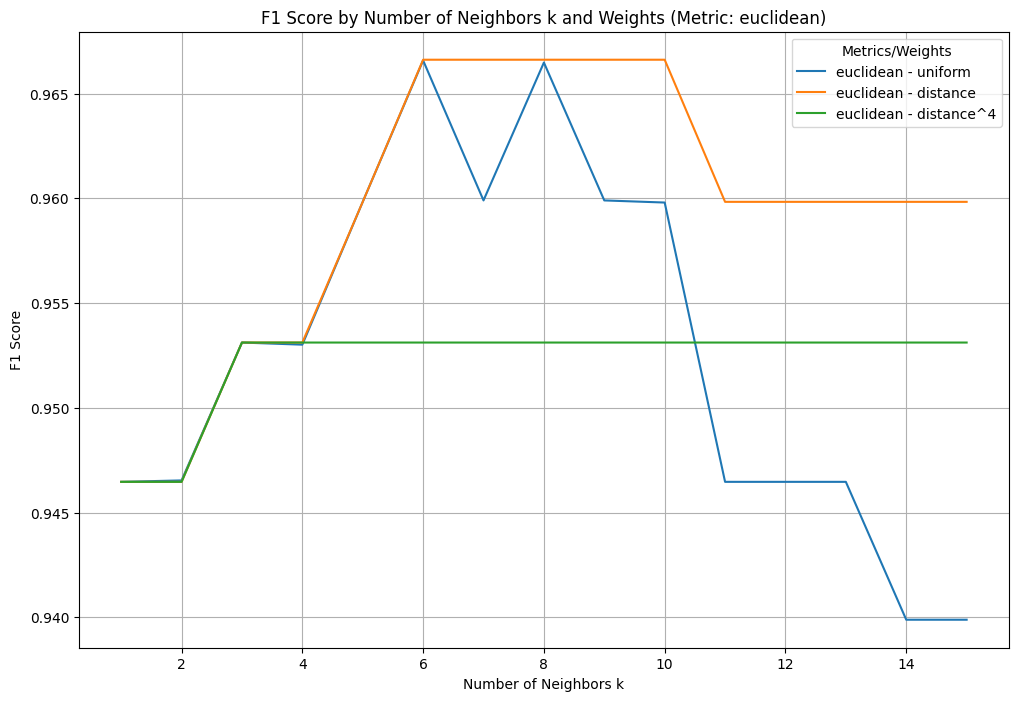

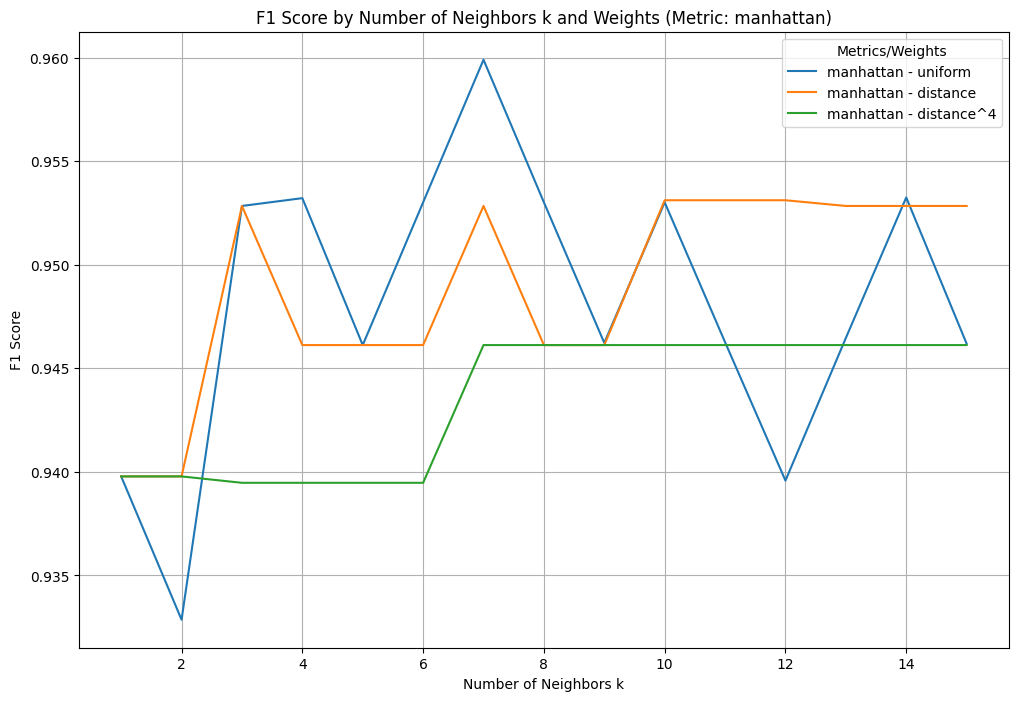

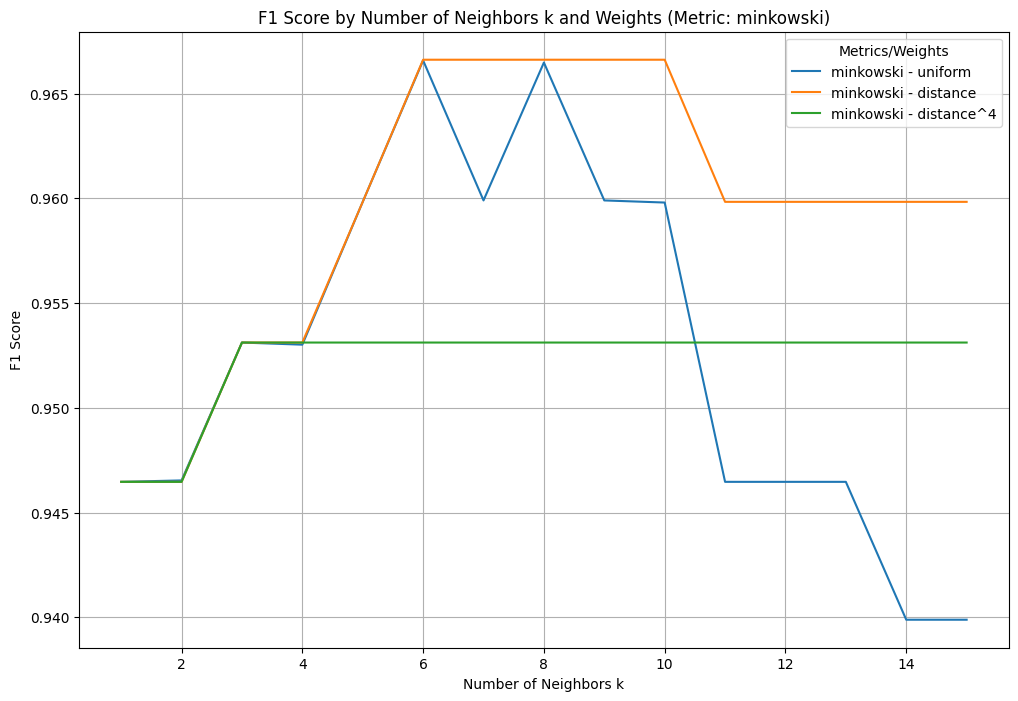

Best combination
(6, 'euclidean', 'distance')


In [125]:
test_params(X_iris, y_iris)

# WINE

In [126]:
wine: UciMlDataset = fetch_ucirepo(id=109)

In [127]:
X_wine = wine.data.features
y_wine = wine.data.targets

## kNN without cross validation

In [128]:
test_knn(X_wine, y_wine)

              precision    recall  f1-score   support

           1       0.93      1.00      0.97        14
           2       1.00      0.86      0.92        14
           3       0.89      1.00      0.94         8

    accuracy                           0.94        36
   macro avg       0.94      0.95      0.94        36
weighted avg       0.95      0.94      0.94        36

[[14  0  0]
 [ 1 12  1]
 [ 0  0  8]]


## k-NN with cross validation

In [129]:
test_cross_validation(X_wine, y_wine)

,folds,test_accuracy,test_precision,test_recall,test_f1
0,2,0.943842,0.950471,0.953535,0.947432
1,5,0.957882,0.958990,0.965152,0.959259
2,10,0.936946,0.938855,0.946633,0.938396


### Cross validation results for WINE dataset

With cross validation the results were better than without cross validation.
The best result was obtained with 5-fold cross validation.

f1
k  metric    weight              
1  euclidean uniform     0.950612
             distance    0.950612
             distance^4  0.950612
   manhattan uniform     0.961228
             distance    0.961228
...                           ...
15 manhattan distance    0.967530
             distance^4  0.972864
   minkowski uniform     0.956423
             distance    0.956423
             distance^4  0.955915

[135 rows x 1 columns]

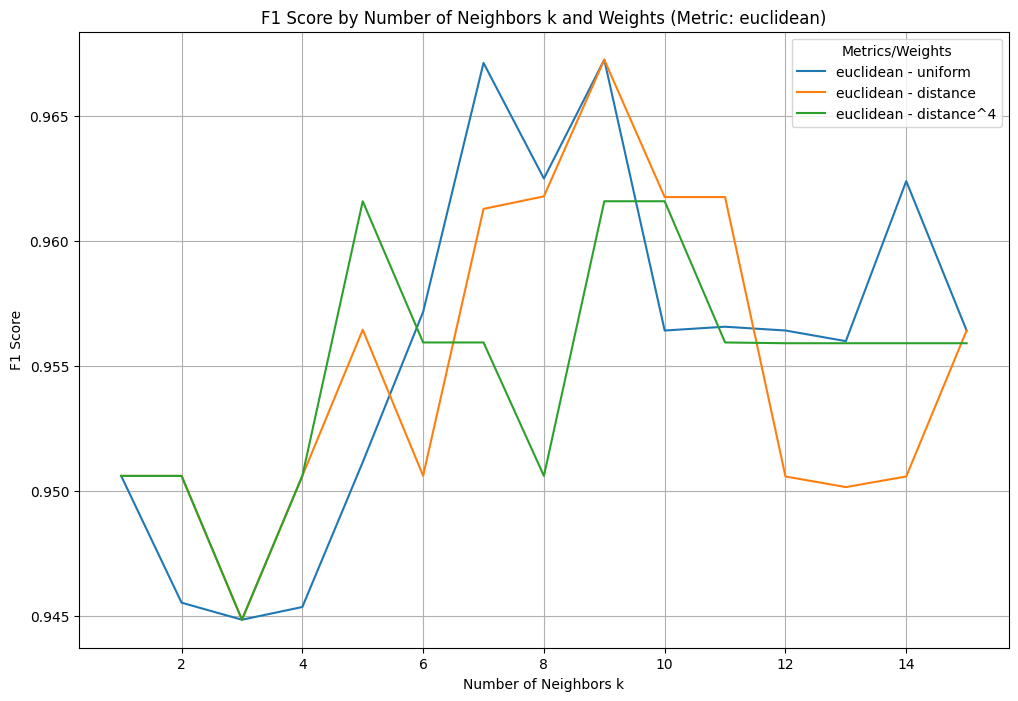

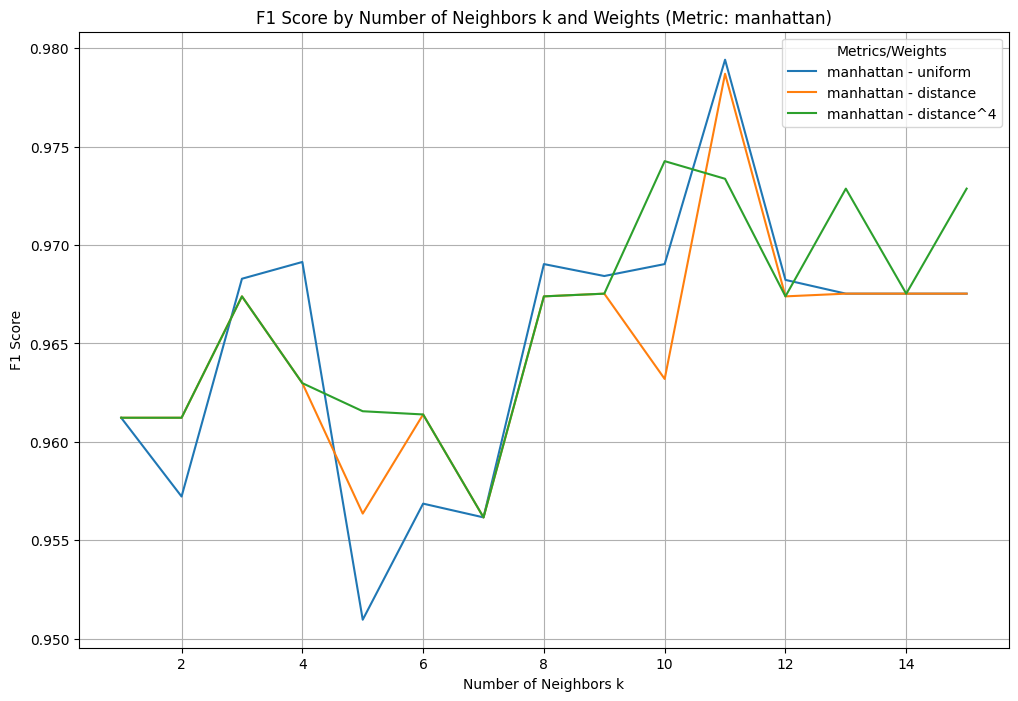

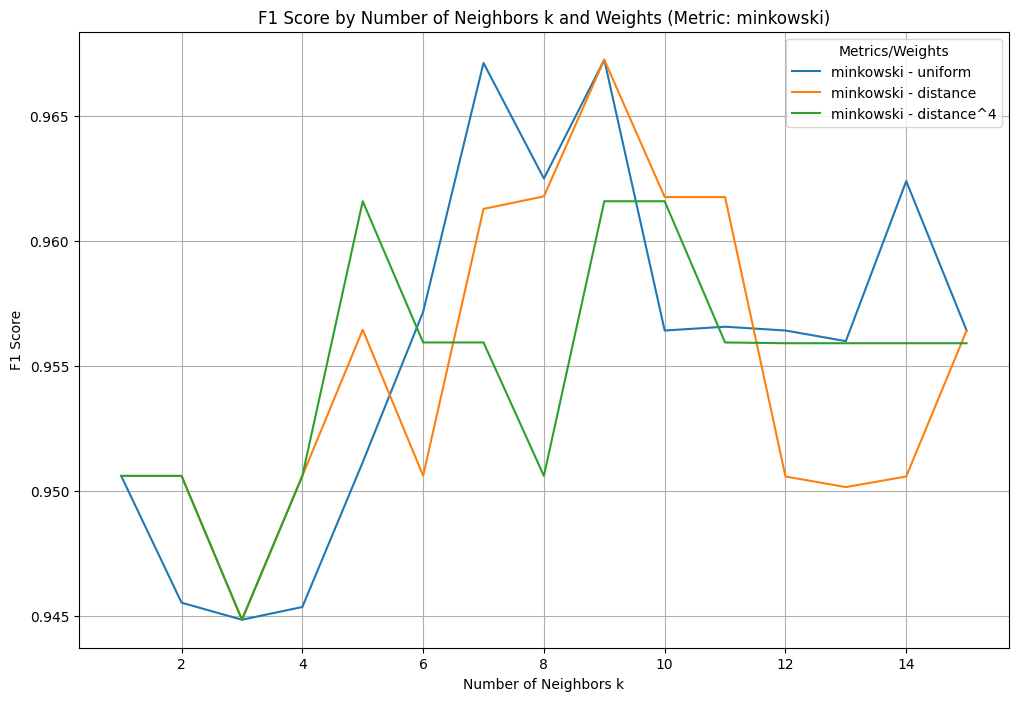

Best combination
(11, 'manhattan', 'uniform')


In [130]:
test_params(X_wine, y_wine)

# Polish Companies Bankruptcy Data (PCB)

In [131]:
pcb: UciMlDataset = fetch_ucirepo(id=365)

X_pcb = pcb.data.features
y_pcb = pcb.data.targets

## k-NN without cross validation

In [132]:
test_knn(X_pcb, y_pcb)

ValueError: Input X contains NaN.
KNeighborsClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values